In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm import tqdm

In [2]:
pid = pd.read_csv("./articles.csv")
pid.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [3]:
data = pd.read_csv("./transaction_sample.csv")

del data["sales_channel_id"]
data.head(2)

,t_dat,customer_id,article_id,price
0,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.033881
1,2018-09-20,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...,673531001,0.008458


In [4]:
data["t_dat"] = pd.to_datetime(data["t_dat"])

data["month"] = data["t_dat"].dt.month
data["year"] = data["t_dat"].dt.year
data.head(2)

,t_dat,customer_id,article_id,price,month,year
0,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.033881,9,2018
1,2018-09-20,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...,673531001,0.008458,9,2018


In [5]:
entity2idx = lambda data: {item: idx for idx, item in enumerate(data)}
idx2entity = lambda entity2idx: {idx: entity for entity, idx in entity2idx.items()}

user2idx = entity2idx(data.customer_id.unique())
idx2user = idx2entity(user2idx)

pid2idx = entity2idx(data.article_id.unique())
idx2pid = idx2entity(pid2idx)

In [6]:
data.customer_id = data.customer_id.map(user2idx)
data.article_id = data.article_id.map(pid2idx)
pid.article_id = pid.article_id.map(pid2idx)

data.head(3)

,t_dat,customer_id,article_id,price,month,year
0,2018-09-20,0,0,0.033881,9,2018
1,2018-09-20,1,1,0.008458,9,2018
2,2018-09-20,1,2,0.022017,9,2018


In [7]:
data = data.merge(
    pid[["article_id", "product_type_name"]].drop_duplicates(),
    on=["article_id"],
    how="inner",
)
data.head(2)

,t_dat,customer_id,article_id,price,month,year,product_type_name
0,2018-09-20,0,0,0.033881,9,2018,Trousers
1,2018-09-21,2261,0,0.033881,9,2018,Trousers


# Analytics

In [8]:
from typing import List, Tuple


def plot(data, X, Y, topk=None, mode="count", plot_type="bar", figsize=(10, 4)):
    """
    Count/Mean of Y for every X
    Create a bar plot and pie chart based on the plot_type argument.
    """
    group = data.groupby(X)[Y]
    group = (
        group.mean()
        if mode == "mean"
        else group.nunique()
        if mode == "unique count"
        else group.count()
    )

    group = (
        group.nlargest(topk).reset_index() if topk is not None else group.reset_index()
    )

    x_axis = group[X]
    x_axis = ["\n".join(str(x).split(" ")) for x in x_axis]
    y_axis = group[Y]

    plt.figure(figsize=figsize)

    if plot_type == "pie":
        plt.pie(y_axis, labels=x_axis, autopct="%1.1f%%", startangle=140)

    else:
        sns.barplot(x=x_axis, y=y_axis)

    plt.xticks(fontsize=10, rotation=90)
    plt.grid(color="black", linestyle="-", linewidth=1, alpha=0.3)
    plt.title(f"{Y} distribution for {X}")


def time_plot(
    data: pd.DataFrame,
    filter_col: List,
    time_col: List,
    agg_col: str,
    xcol_name: str,
    ycol_name: str,
    figsize: Tuple = (10, 4),
    title: str = None,
):
    # group by filter and time columns and calculate the count of aggregate column
    data = (
        data.groupby(filter_col + time_col)[agg_col].count().reset_index(name="count")
    )
    data.sort_values(by=filter_col + time_col, ascending=True, inplace=True)

    # aggregate all filter columns for filtering and plotting iteratively
    data["temp"] = data[filter_col[0]]
    for col in filter_col[1:]:
        data["temp"] = data["temp"] + " " + data[col]

    # plot graphs for each value in temp
    unique_values = data["temp"].unique()
    assert len(unique_values) < 10, "Can not plot more than 10 graphs.."

    for value in unique_values:
        data_cut = data[data["temp"] == value]

        # values for x axis
        x = data_cut[time_col[0]].astype(str)

        for tc in time_col[1:]:
            x = x + "-" + data_cut[tc].astype(str)

        # values for y axis
        y = data_cut["count"]

        # plot
        plt.figure(figsize=figsize)
        plt.plot(x, y, marker="o", linestyle="-")

        plt.xlabel(xcol_name)
        plt.ylabel(ycol_name)
        plt.title(f"{ycol_name} vs {xcol_name} - {value}" if title is None else title)
        plt.grid(True)

        plt.show()

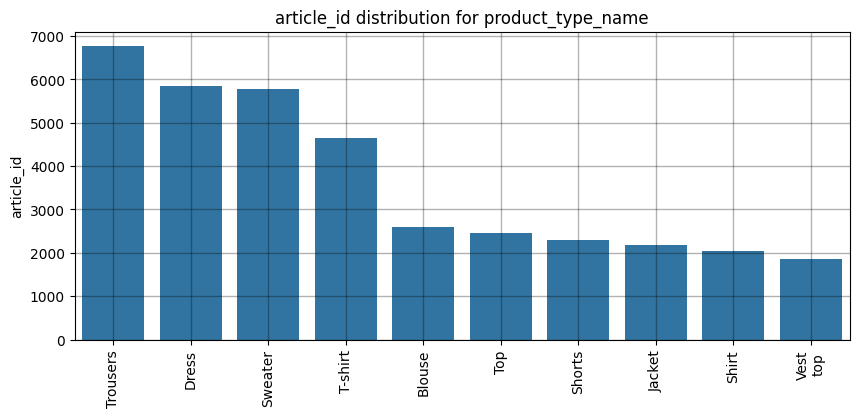

In [9]:
"""
count of products in the catalog per category
"""
plot(
    data,
    X="product_type_name",
    Y="article_id",
    topk=10,
    mode="unique count",
    plot_type="bar",
    figsize=(10, 4),
)

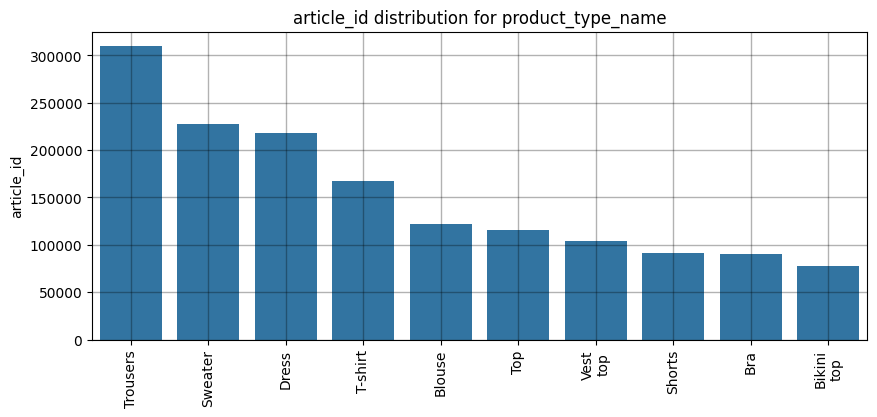

In [10]:
"""
count of product sold per category
"""
plot(
    data,
    X="product_type_name",
    Y="article_id",
    topk=10,
    mode="count",
    plot_type="bar",
    figsize=(10, 4),
)

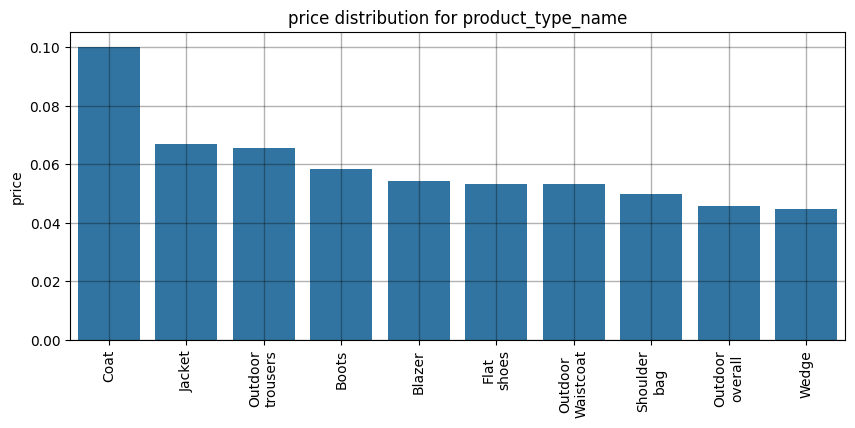

In [11]:
"""
average product price per category
"""
plot(
    data,
    X="product_type_name",
    Y="price",
    topk=10,
    mode="mean",
    plot_type="bar",
    figsize=(10, 4),
)

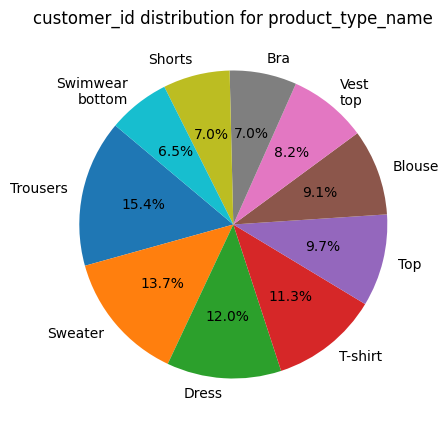

In [12]:
"""
unique count of users per category
"""
plot(
    data,
    X="product_type_name",
    Y="customer_id",
    topk=10,
    mode="unique count",
    plot_type="pie",
    figsize=(5, 5),
)

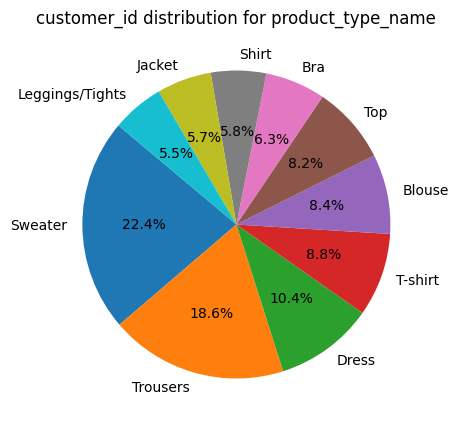

In [13]:
"""
unique count of users per category in winter
"""
data_cut = data[data["month"].isin([10, 11, 12])].copy()
plot(
    data_cut,
    X="product_type_name",
    Y="customer_id",
    topk=10,
    mode="unique count",
    plot_type="pie",
    figsize=(5, 5),
)

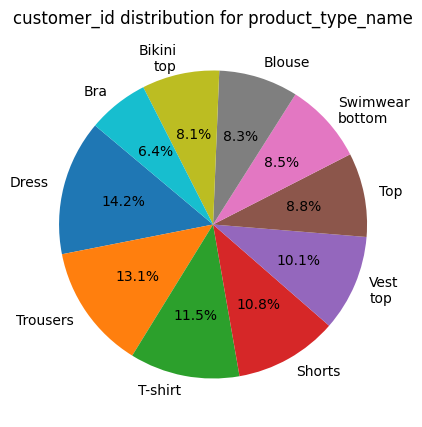

In [14]:
"""
unique count of users per category in summer
"""
data_cut = data[data["month"].isin([6, 7, 8])].copy()
plot(
    data_cut,
    X="product_type_name",
    Y="customer_id",
    topk=10,
    mode="unique count",
    plot_type="pie",
    figsize=(5, 5),
)

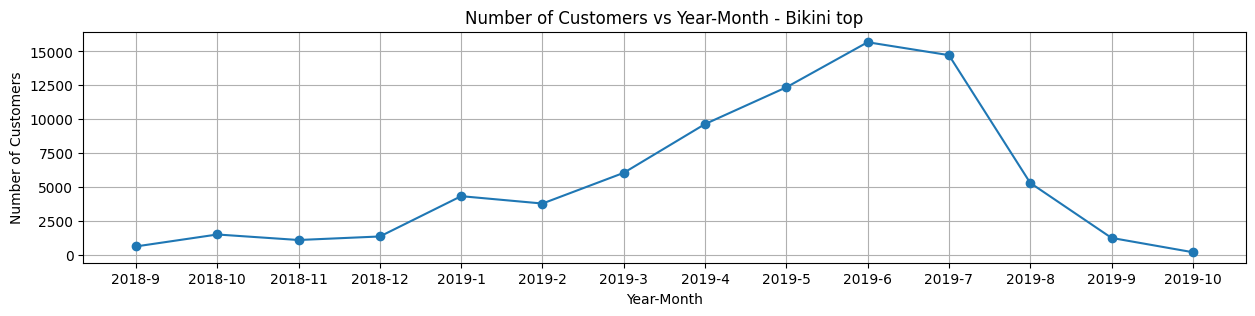

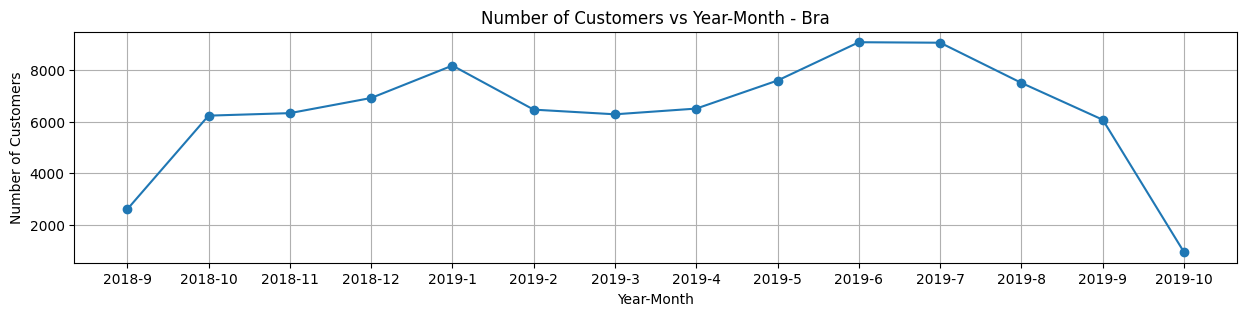

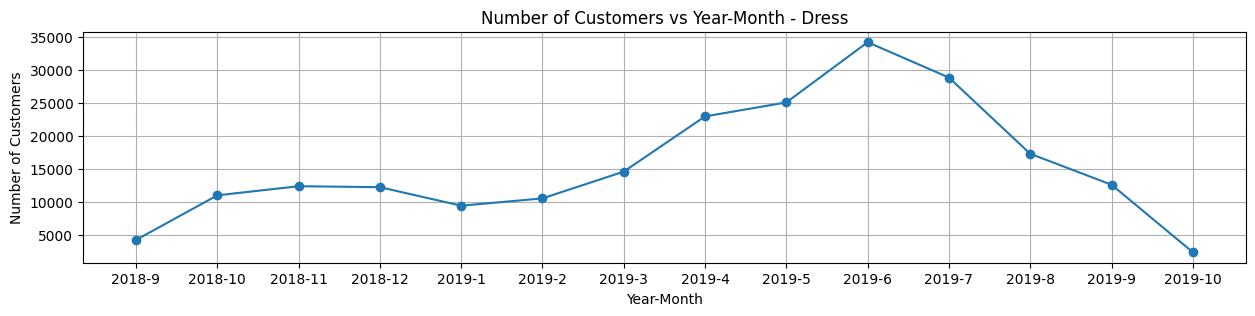

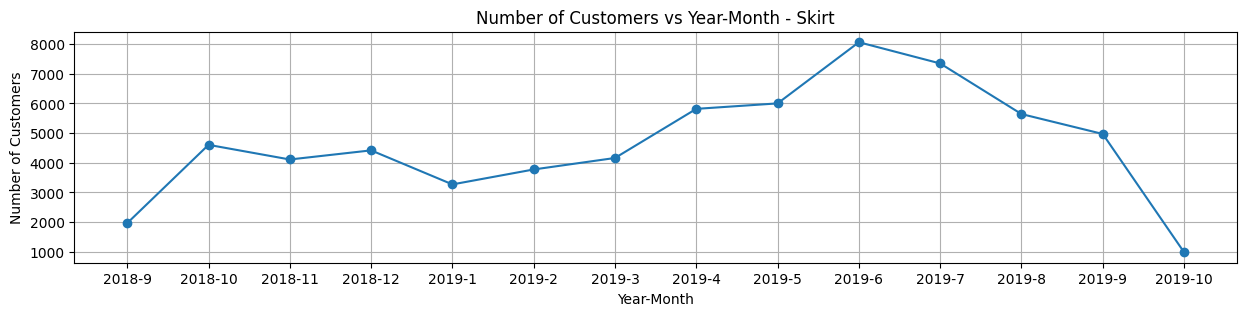

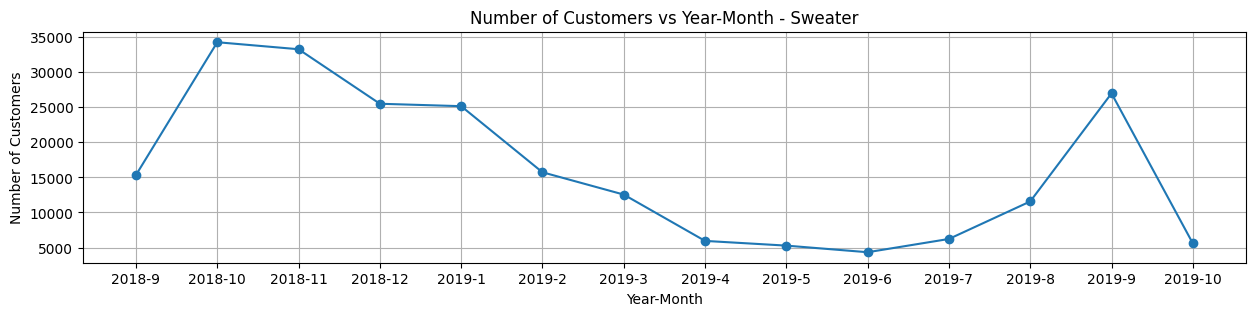

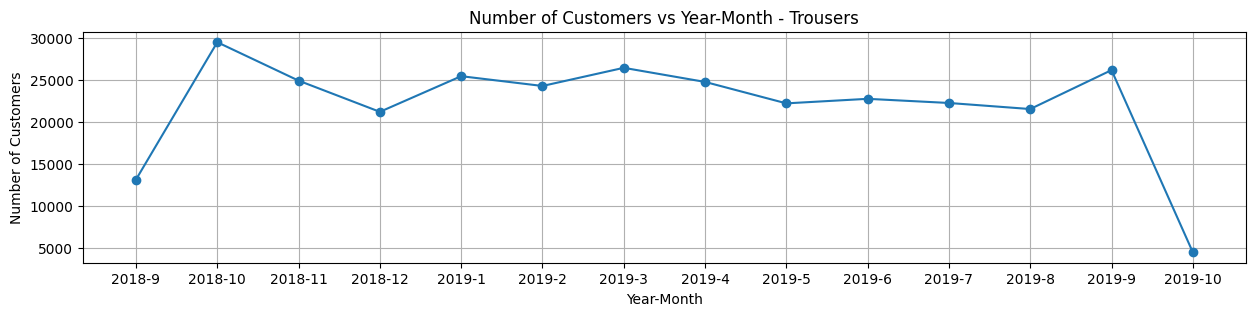

In [15]:
"""
time series plot for "Sweater", "Bra", "Bikini top", "Skirt", "Trousers", "Dress" categories
"""
time_plot(
    data[
        data["product_type_name"].isin(
            ["Sweater", "Bra", "Bikini top", "Skirt", "Trousers", "Dress"]
        )
    ].copy(),
    filter_col=["product_type_name"],
    time_col=["year", "month"],
    agg_col="customer_id",
    xcol_name="Year-Month",
    ycol_name="Number of Customers",
    figsize=(15, 3),
)

In [16]:
# average number of products per customer
product_count_per_user = (
    data.groupby("customer_id")["article_id"].nunique().reset_index(name="count")
)
series = product_count_per_user["count"]

print(series.quantile([0.10, 0.25, 0.50, 0.75, 0.90]))
f"mean: {series.mean()}", f"max: {series.max()}", f"min: {series.min()}"

0.10     1.0
0.25     3.0
0.50     7.0
0.75    18.0
0.90    36.0
Name: count, dtype: float64


('mean: 14.805975713677034', 'max: 503', 'min: 1')

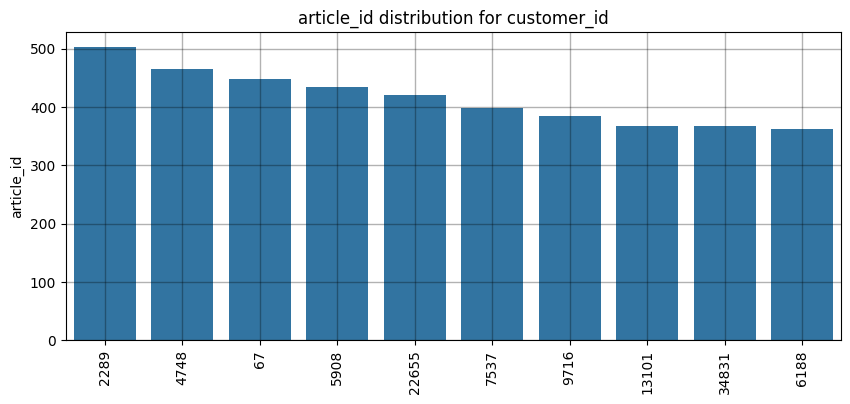

In [17]:
"""
number of articles bought by the top 10 users
"""
plot(data, X="customer_id", Y="article_id", topk=10, mode="unique count", plot_type="bar")

# Modelling: Neural Collaborative Filtering (BPR)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [10]:
from typing import List
import logging


logging.basicConfig(
    level=logging.DEBUG, format="[%(asctime)s]  [%(levelname)s]  %(message)s"
)


class DataUtil:
    def __init__(self, data: List[List], nusers: int, nitems: int):
        """
        interactions:
            data: [[user1, item1], [user1, item2]]
        """
        self.nusers = nusers
        self.nitems = nitems
        self.data = data

        # interactions data
        logging.info("building interaction matrix..")
        self.interaction_matrix = sp.dok_matrix((nusers, nitems), dtype=np.float32)

        for user, item in tqdm(data):
            self.interaction_matrix[user, item] = 1

    def data_sample(self, count_per_user=10):
        logging.info("sampling data..")
        samples = []
        nitems = self.interaction_matrix.shape[1]

        for user, positive_item in tqdm(self.data):
            for _ in range(count_per_user):
                negative_item = np.random.randint(nitems)

                while (user, negative_item) in self.interaction_matrix:
                    negative_item = np.random.randint(nitems)

                samples.append([user, positive_item, negative_item])
        return samples

In [11]:
class CDataset(Dataset):
    def __init__(self, data_obj, num_negative_sample=10):
        self.data = data_obj.data_sample(count_per_user=num_negative_sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, pos_item, neg_item = self.data[idx]
        return user, pos_item, neg_item

In [12]:
data_obj = DataUtil(
    data=data[["customer_id", "article_id"]].values.tolist(),
    nusers=len(user2idx),
    nitems=len(pid2idx),
)

[2023-10-02 13:17:27,474]  [INFO]  building interaction matrix..
100%|█████████████████████████████████████████████████| 2337994/2337994 [00:08<00:00, 268164.04it/s]


In [13]:
train_num_negative_sample = 10
train_batch_size = train_num_negative_sample * 500

test_num_negative_sample = 5
test_batch_size = test_num_negative_sample * 50

train_dataset = CDataset(data_obj, train_num_negative_sample)
test_dataset = CDataset(data_obj, test_num_negative_sample)

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0
)

[2023-10-02 13:17:36,206]  [INFO]  sampling data..
100%|██████████████████████████████████████████████████| 2337994/2337994 [00:37<00:00, 63048.48it/s]
[2023-10-02 13:18:13,290]  [INFO]  sampling data..
100%|█████████████████████████████████████████████████| 2337994/2337994 [00:19<00:00, 123011.23it/s]


In [14]:
train_dataset[0], test_dataset[0]

((0, 0, 12126), (0, 0, 58184))

In [15]:
class NCF(nn.Module):
    def __init__(self, nusers, nitems, emb_dim, dropout=0.1):
        super(NCF, self).__init__()
        self.users = nn.Embedding(nusers, emb_dim)
        self.items = nn.Embedding(nitems, emb_dim)

        nn.init.normal_(self.users.weight, std=0.01)
        nn.init.normal_(self.items.weight, std=0.01)

        self.dropout = nn.Dropout(dropout)

    def forward(self, user, pos_item, neg_item):
        user = self.dropout(self.users(user))
        pos_item = self.dropout(self.items(pos_item))
        neg_item = self.dropout(self.items(neg_item))

        pos_score = (user * pos_item).sum(-1)
        neg_score = (user * neg_item).sum(-1)

        return pos_score, neg_score

    def predict(self, user, item):
        return (self.users(user) * self.items(item)).sum(-1)

In [16]:
device = torch.device("mps")
model = NCF(nusers=len(user2idx), nitems=len(pid2idx), emb_dim=128).to(device)
model

NCF(
  (users): Embedding(150208, 128)
  (items): Embedding(61542, 128)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [17]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=0.2, weight_decay=1e-2)

In [18]:
def train(epoch, model, optimizer, criterion, dataloader, device):
    model.train()

    pbar = tqdm(dataloader)

    train_loss = 0
    correct = 0
    processed = 0

    for minibatch, (user, pos_item, neg_item) in enumerate(pbar):
        user = user.to(device)
        pos_item = pos_item.to(device)
        neg_item = neg_item.to(device)

        pos_score, neg_score = model(user, pos_item, neg_item)

        target = torch.ones_like(pos_score, dtype=torch.float).to(device)
        loss = criterion(pos_score - neg_score, target)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        processed += user.size(0)
        correct += ((pos_score - neg_score) > 0).detach().count_nonzero().item()
        accuracy = round(100 * correct / processed, 2)

        pbar.set_description(
            f"Epoch: {epoch} MiniBatch: {minibatch+1} Loss: {train_loss / processed} Accuracy: {accuracy}"
        )

    return train_loss / len(dataloader)

In [19]:
def test(epoch, model, criterion, dataloader, device):
    model.eval()

    pbar = tqdm(dataloader)

    test_loss = 0
    correct = 0
    processed = 0

    with torch.no_grad():
        for minibatch, (user, pos_item, neg_item) in enumerate(pbar):
            user = user.to(device)
            pos_item = pos_item.to(device)
            neg_item = neg_item.to(device)

            pos_score, neg_score = model(user, pos_item, neg_item)

            loss = -(pos_score - neg_score).sigmoid().log().sum()
            test_loss += loss.item()

            processed += user.size(0)
            correct += ((pos_score - neg_score) > 0).count_nonzero().item()
            accuracy = round(100 * correct / processed, 2)

            pbar.set_description(
                f"Epoch: {epoch} MiniBatch: {minibatch+1} Loss: {test_loss / processed} Accuracy: {accuracy}"
            )

        return test_loss / len(dataloader)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train(epoch, model, optimizer, criterion, train_loader, device)
    test(epoch, model, criterion, test_loader, device)

Epoch: 0 MiniBatch: 4676 Loss: 0.3849341866673919 Accuracy: 86.05: 100%|█| 4676/4676 [02:50<00:00, 2
Epoch: 1 MiniBatch: 4676 Loss: 0.3140894220343112 Accuracy: 90.86: 100%|█| 4676/4676 [02:56<00:00, 2
Epoch: 2 MiniBatch: 4676 Loss: 0.3093696366354404 Accuracy: 91.28: 100%|█| 4676/4676 [03:00<00:00, 2
Epoch: 3 MiniBatch: 4676 Loss: 0.30853591534446334 Accuracy: 91.36: 100%|█| 4676/4676 [03:00<00:00, 
Epoch: 4 MiniBatch: 4676 Loss: 0.3083422887296091 Accuracy: 91.37: 100%|█| 4676/4676 [02:56<00:00, 2
Epoch: 4 MiniBatch: 16324 Loss: 0.3409138598527373 Accuracy: 90.13:  35%|▎| 16311/46760 [00:44<01:18

In [46]:
from typing import List


def nns(model, device, nitems: int, user_id: List):
    with torch.no_grad():
        item_scores = (model.users(torch.tensor(user_id, device=device)) * model.items.weight.data).sum(-1)
        score, indices = torch.topk(item_scores, k=nitems)

    return list(zip(indices.tolist(), score.tolist()))

In [66]:
user_id = 1
n = 100

In [68]:
# recommendations
reco = pd.DataFrame(nns(model, device, n, [user_id]), columns=["article_id", "score"])
reco.merge(pid, how="inner")["product_group_name"].unique()

array(['Garment Lower body', 'Accessories', 'Garment Upper body',
       'Socks & Tights', 'Underwear', 'Garment Full body', 'Swimwear',
       'Shoes'], dtype=object)

In [69]:
# items actually bought
data[data["customer_id"] == user_id].merge(pid, how="inner")["product_group_name"].unique()

array(['Accessories', 'Underwear', 'Garment Upper body',
       'Garment Full body', 'Garment Lower body', 'Socks & Tights'],
      dtype=object)